In [1]:
from ortools.sat.python import cp_model
import numpy as np
import sys
import ortools
import matplotlib.pyplot as plt
import itertools

# Sokoban

Sokoban is a classic puzzle video game where the player takes on the role of a warehouse worker (or "Sokoban," which means "warehouse keeper" in Japanese) tasked with pushing boxes or crates onto designated storage locations within a grid-like environment. The challenge is to move the boxes to their target locations without getting stuck.

In [2]:
# 0 = empty,  1 = box, 2 = person, 10 = blocked

grid = [[10,10,10,10,10,10,10,10],
        [10,10,10,0,0,0,10,10],
        [10,0,2,1,0,0,10,10],
        [10,10,10,0,1,0,10,10],
        [10,0,10,10,1,0,10,10],
        [10,0,10,0,0,0,10,10],
        [10,1,0,1,1,1,0,10],
        [10,0,0,0,0,0,0,10],
        [10,10,10,10,10,10,10,10]]
target = [(2,1), (3,5), (4,1), (5,4), (6,3), (6,6), (7,4)]


# grid = [[10,10,10,10,10,10,10,10,10,10,10,10,10,10],
#         [10,0,0,0,0,10,0,0,0,0,0,10,10,10],
#         [10,0,0,0,0,10,0,1,0,0,1,0,0,10],
#         [10,0,0,0,0,10,1,10,10,10,10,0,0,10],
#         [10,0,0,0,0,0,0,2,0,10,10,0,0,10],
#         [10,0,0,0,0,10,0,10,0,0,1,0,10,10],
#         [10,10,10,10,10,10,0,10,10,1,0,1,0,10],
#         [10,10,10,0,1,0,0,1,0,1,0,1,0,10],
#         [10,10,10,0,0,0,0,10,0,0,0,0,0,10],
#         [10,10,10,10,10,10,10,10,10,10,10,10,10,10]]
# target = [(1,1),(1,2),(2,1),(2,2),(3,1),(3,2),(4,1),(4,2),(5,1),(5,2)]

# Size of the grid
rows = range(len(grid))
cols = range(len(grid[0]))

blocked = np.reshape([0 if grid[i][j] != 10 else 1 for i in rows for j in cols], (len(rows),len(cols)))
cube = np.reshape([0 if grid[i][j] != 1 else 1 for i in rows for j in cols], (len(rows),len(cols)))
person = np.reshape([0 if grid[i][j] != 2 else 1 for i in rows for j in cols], (len(rows),len(cols)))

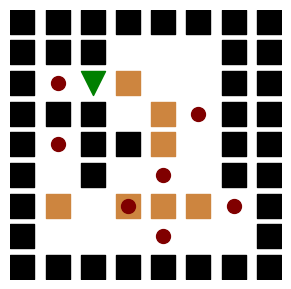

In [17]:
size = 300

features = {0: {'color': 'w', 'marker': 's'},
         1: {'color': 'peru', 'marker': 's'},
         2: {'color': 'g', 'marker': 'v'},
         10: {'color': 'k', 'marker': 's'}}

plt.figure(figsize=(3.5,3.5))
# plt.figure(figsize=(5,4))

for i in rows:
    for j in cols:
        if (i,j) in target:
            plt.scatter(j,len(cols)-i, marker = 'o', s = 100, c = 'maroon', zorder = 2)
        plt.scatter(j,len(cols)-i, marker = features[grid[i][j]]['marker'], s= size, c = features[grid[i][j]]['color'])

plt.axis('off');

In [19]:
# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

# Arbitrary mumber of stages, can be changed
S = range(40)

# Cell variables at each stage
p = {(i,j,s): model.NewBoolVar(f'p_{i}_{j}_{s}') for i in rows for j in cols for s in S}
c = {(i,j,s): model.NewBoolVar(f'c_{i}_{j}_{s}') for i in rows for j in cols for s in S}
b = {(i,j,s): model.NewBoolVar(f'b_{i}_{j}_{s}') for i in rows for j in cols for s in S}

# Direction that player moves
up = {(i,j,s): model.NewBoolVar(f'up_{i}_{j}_{s}') for i in rows for j in cols for s in S}
down = {(i,j,s): model.NewBoolVar(f'down_{i}_{j}_{s}') for i in rows for j in cols for s in S}
left = {(i,j,s): model.NewBoolVar(f'left_{i}_{j}_{s}') for i in rows for j in cols for s in S}
right = {(i,j,s): model.NewBoolVar(f'right_{i}_{j}_{s}') for i in rows for j in cols for s in S}

# Termination {1 if terminated, 0 otherwise}
term = {(s): model.NewBoolVar(f'term_{s}') for s in S}

# Initializing grid
for i in rows:
    for j in cols:
        model.Add(p[i,j,0] == person[i][j])
        model.Add(c[i,j,0] == cube[i][j])
        model.Add(b[i,j,0] == blocked[i][j])

# Model must terminate
model.AddAtLeastOne([term[s] for s in S])

for s in S:

    # Only one choice per state
    model.Add(sum(left[i,j,s] + right[i,j,s] + up[i,j,s] + down[i,j,s] for i in rows for j in cols) <= 1)
    # If terminated, then the sum of the selected locations of the puzzle must be equal to the number of all cubes
    model.Add(sum(c[i,j,s] for i in rows for j in cols if (i,j) in target) == len(target)).OnlyEnforceIf(term[s])
    model.Add(sum(left[i,j,s] + right[i,j,s] + up[i,j,s] + down[i,j,s] for i in rows for j in cols) == 0).OnlyEnforceIf(term[s])

    if s > 0:
        # Always only one player on board
        model.AddExactlyOne([p[i,j,s] for i in rows for j in cols])
        # Always exactly target number of cubes
        model.Add(sum(c[i,j,s] for i in rows for j in cols) == len(target))

        if s != S:
            # If terminated in the step, then next step must be terminated
            model.Add(term[s-1] <= term[s])
        for i in rows:
            for j in cols:
                # Each cell on board must not have 2 of any person, block, or crate combo
                model.AddAtMostOne([p[i,j,s], b[i,j,s], c[i,j,s]])

                none1 = [up[i,j,s].Not() for i in rows for j in cols]
                none2 = [down[i,j,s].Not() for i in rows for j in cols]
                none3 = [left[i,j,s].Not() for i in rows for j in cols]
                none4 = [right[i,j,s].Not() for i in rows for j in cols]
                none = none1 + none2 + none3 + none4
                # Player doesn't move if no move is made
                model.Add(p[i,j,s-1] == p[i,j,s]).OnlyEnforceIf(none)
                # Cube doesn't move if no move is made
                model.Add(c[i,j,s-1] == c[i,j,s]).OnlyEnforceIf(none)
                                                                                                             
                # Boundaries stay the same
                if grid[i][j] == 10:
                    model.Add((left[i,j,s] + right[i,j,s] + up[i,j,s] + down[i,j,s]) == 0)
                    model.Add(b[i,j,s-1] == b[i,j,s])
                    continue

                # Up
                if i <= 1:
                    # Cannot move up when at the top row
                    model.Add(up[i,j,s] == 0)
                if i>1:
                    # If up, then cell is person
                    model.Add(p[i,j,s-1] == 1).OnlyEnforceIf(up[i,j,s])
                    # If up and no cube then person moves up and his spot is now empty
                    model.Add(p[i-1,j,s] == 1).OnlyEnforceIf(up[i,j,s])

                    # If up, then cell above not blocking
                    model.Add(b[i-1,j,s-1]==0).OnlyEnforceIf(up[i,j,s])

                    # If up and cube above, then no cube or blocking 2 spaces above
                    model.Add(c[i-2,j,s-1] + b[i-2,j,s-1]==0).OnlyEnforceIf(up[i,j,s],c[i-1,j,s-1])

                    # If up and cube, then person and cube move up
                    model.Add(c[i-2,j,s] == 1).OnlyEnforceIf(up[i,j,s],c[i-1,j,s-1])
                    model.Add(c[i-1,j,s] == 0).OnlyEnforceIf(up[i,j,s],c[i-1,j,s-1])

                    # If up, then all other cubes locations stay the same
                    for x in rows:
                        for y in cols:
                            if (x,y) not in [(i-1,j), (i-2,j)]:
                                model.Add(c[x,y,s-1] == c[x,y,s]).OnlyEnforceIf(up[i,j,s])
                # Down
                if i >= len(rows) - 2:
                    # Cannot move down when at the bottom row
                    model.Add(down[i,j,s] == 0)
                if i< len(rows) - 2:
                    # If down, then cell is person
                    model.Add(p[i,j,s-1] == 1).OnlyEnforceIf(down[i,j,s])
                    # If down and no cube then person moves up and his spot is now empty
                    model.Add(p[i+1,j,s] == 1).OnlyEnforceIf(down[i,j,s])

                    # If down, then cell below not blocking
                    model.Add(b[i+1,j,s-1]==0).OnlyEnforceIf(down[i,j,s])

                    # If down and cube below, then no cube or blocking 2 spaces below
                    model.Add(c[i+2,j,s-1] + b[i+2,j,s-1]==0).OnlyEnforceIf(down[i,j,s],c[i+1,j,s-1])

                    # If down and cube, then person and cube move down
                    model.Add(c[i+2,j,s] == 1).OnlyEnforceIf(down[i,j,s],c[i+1,j,s-1])
                    model.Add(c[i+1,j,s] == 0).OnlyEnforceIf(down[i,j,s],c[i+1,j,s-1])

                    # If down, then all other cubes locations stay the same
                    for x in rows:
                        for y in cols:
                            if (x,y) not in [(i+1,j), (i+2,j)]:
                                model.Add(c[x,y,s-1] == c[x,y,s]).OnlyEnforceIf(down[i,j,s])

                # Left
                if j <= 1:
                    # Cannot move left when at the leftmost row
                    model.Add(left[i,j,s] == 0)
                if j>1:
                    # If left, then cell is person
                    model.Add(p[i,j,s-1] == 1).OnlyEnforceIf(left[i,j,s])
                    # If up and no cube then person moves up and his spot is now empty
                    model.Add(p[i,j-1,s] == 1).OnlyEnforceIf(left[i,j,s])

                    # If left, then cell to the left not blocking
                    model.Add(b[i,j-1,s-1]==0).OnlyEnforceIf(left[i,j,s])

                    # If left and cube to the left, then no cube or blocking 2 spaces to the left
                    model.Add(c[i,j-2,s-1] + b[i,j-2,s-1]==0).OnlyEnforceIf(left[i,j,s],c[i,j-1,s-1])

                    # If left and cube, then person and cube move left
                    model.Add(c[i,j-2,s] == 1).OnlyEnforceIf(left[i,j,s],c[i,j-1,s-1])
                    model.Add(c[i,j-1,s] == 0).OnlyEnforceIf(left[i,j,s],c[i,j-1,s-1])

                    # If left, then all other cubes locations stay the same
                    for x in rows:
                        for y in cols:
                            if (x,y) not in [(i,j-1), (i,j-2)]:
                                model.Add(c[x,y,s-1] == c[x,y,s]).OnlyEnforceIf(left[i,j,s])
                # Right
                if j >= len(cols) - 2:
                    # Cannot move right when at the rightmost row
                    model.Add(right[i,j,s] == 0)
                if j<len(cols) - 2:
                    # If right, then cell is person
                    model.Add(p[i,j,s-1] == 1).OnlyEnforceIf(right[i,j,s])
                    # If right and no cube then person moves up and his spot is now empty
                    model.Add(p[i,j+1,s] == 1).OnlyEnforceIf(right[i,j,s])

                    # If right, then cell right not blocking
                    model.Add(b[i,j+1,s-1]==0).OnlyEnforceIf(right[i,j,s])

                    # If right and cube to the right, then no cube or blocking 2 spaces to the right
                    model.Add(c[i,j+2,s-1] + b[i,j+2,s-1]==0).OnlyEnforceIf(right[i,j,s],c[i,j+1,s-1])

                    # If right and cube, then person and cube move to the right
                    model.Add(c[i,j+2,s] == 1).OnlyEnforceIf(right[i,j,s],c[i,j+1,s-1])
                    model.Add(c[i,j+1,s] == 0).OnlyEnforceIf(right[i,j,s],c[i,j+1,s-1])

                    # If right, then all other cubes locations stay the same
                    for x in rows:
                        for y in cols:
                            if (x,y) not in [(i,j+1), (i,j+2)]:
                                model.Add(c[x,y,s-1] == c[x,y,s]).OnlyEnforceIf(right[i,j,s])

# Solving
status = solver.Solve(model)
print(f"Status = {solver.StatusName(status)}")

# Storing Solutions
sol_p = [solver.value(p[i,j,s]) for s in S for i in rows for j in cols]
sol_p = np.reshape(sol_p, (len(S),len(rows),len(cols)))
sol_c= [solver.value(c[i,j,s]) for s in S for i in rows for j in cols]
sol_c = np.reshape(sol_c, (len(S),len(rows),len(cols)))
sol_b = [solver.value(b[i,j,s]) for s in S for i in rows for j in cols]
sol_b = np.reshape(sol_b, (len(S),len(rows),len(cols)))


sol_up = [solver.value(up[i,j,s]) for s in S for i in rows for j in cols]
sol_up = np.reshape(sol_up, (len(S),len(rows),len(cols)))
sol_down = [solver.value(down[i,j,s]) for s in S for i in rows for j in cols]
sol_down = np.reshape(sol_down, (len(S),len(rows),len(cols)))
sol_left = [solver.value(left[i,j,s]) for s in S for i in rows for j in cols]
sol_left = np.reshape(sol_left, (len(S),len(rows),len(cols)))
sol_right = [solver.value(right[i,j,s]) for s in S for i in rows for j in cols]
sol_right = np.reshape(sol_right, (len(S),len(rows),len(cols)))

Status = OPTIMAL


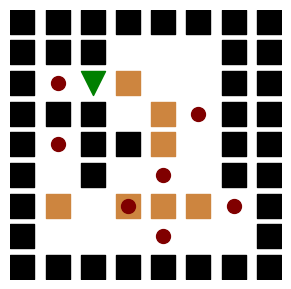

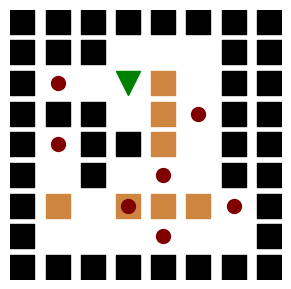

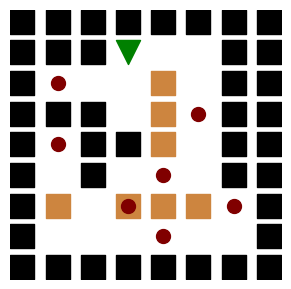

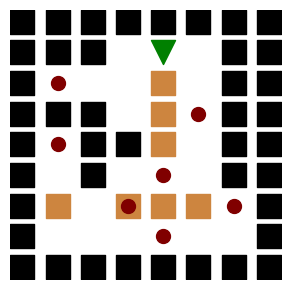

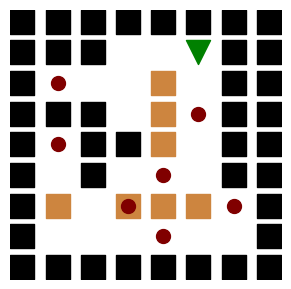

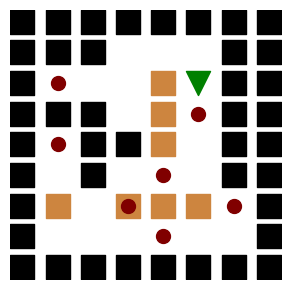

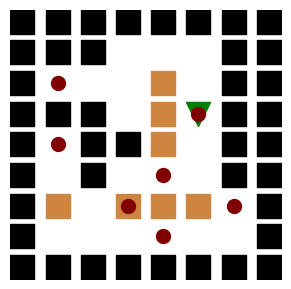

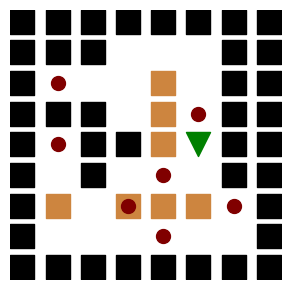

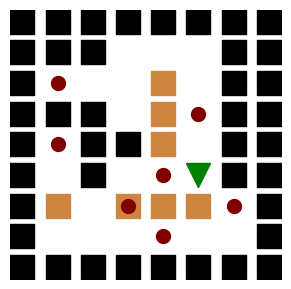

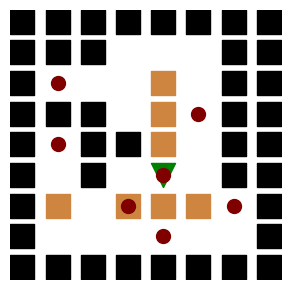

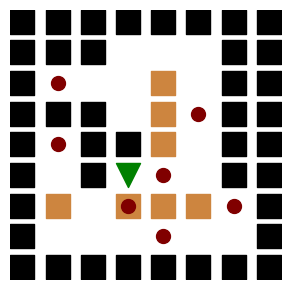

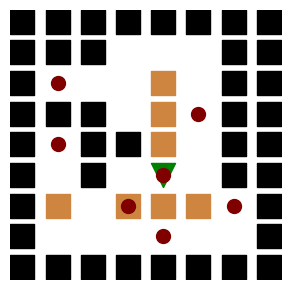

<Figure size 350x350 with 0 Axes>

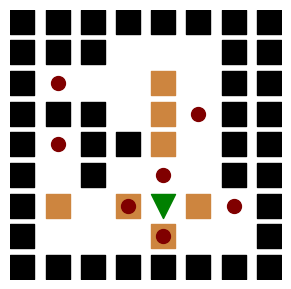

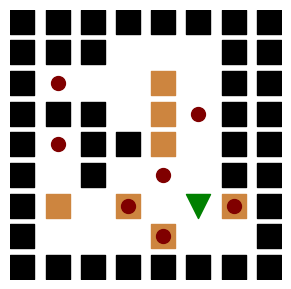

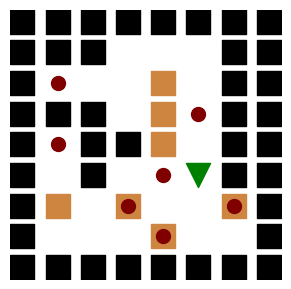

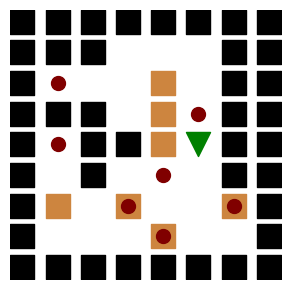

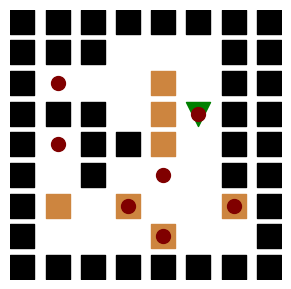

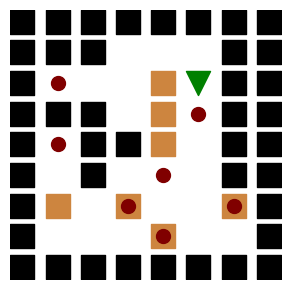

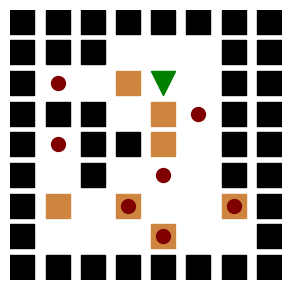

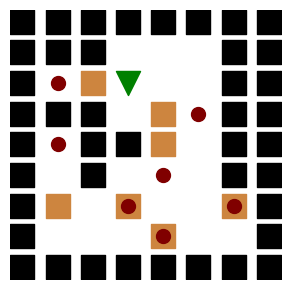

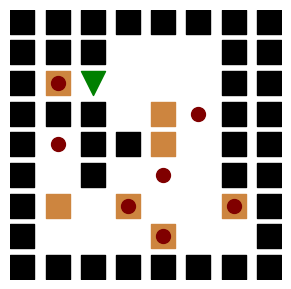

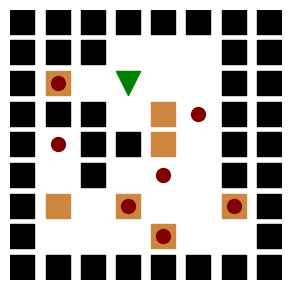

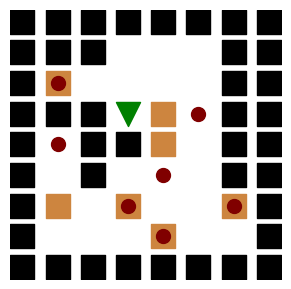

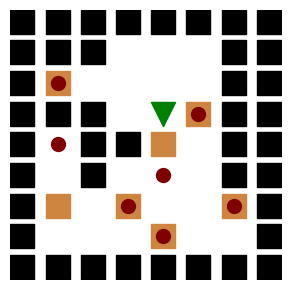

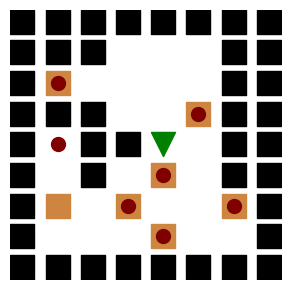

<Figure size 350x350 with 0 Axes>

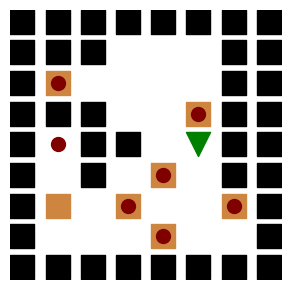

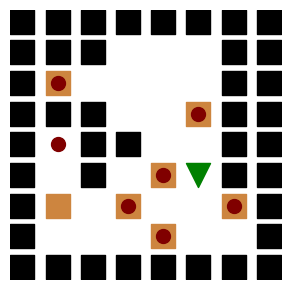

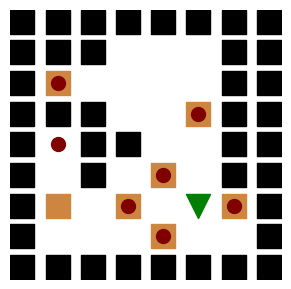

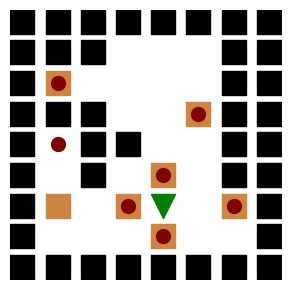

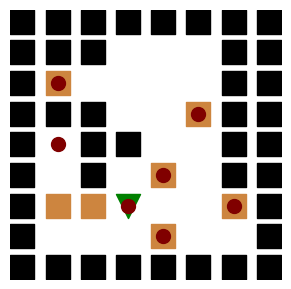

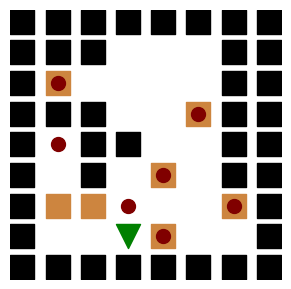

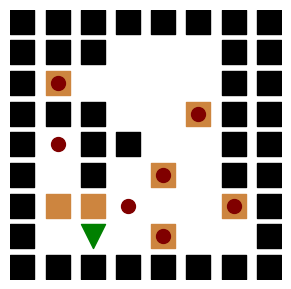

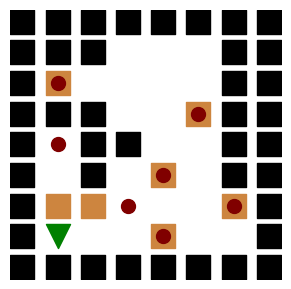

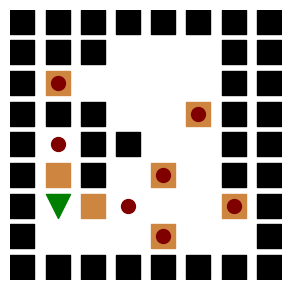

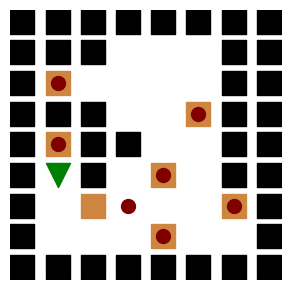

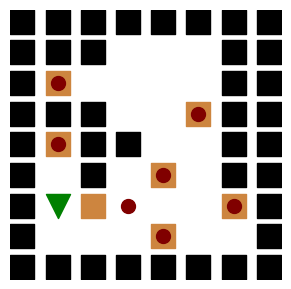

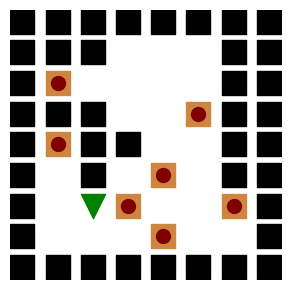

<Figure size 350x350 with 0 Axes>

In [20]:
def feature(s,i,j):
    if sol_p[s,i,j] == 1:
        m = ['g', 'v']
    elif sol_c[s,i,j] == 1:
        m = ['peru', 's']
    elif sol_b[s,i,j] == 1:
        m = ['k', 's']
    else:
        m = ['w', 's']
    return m

for s in S:
    if s > 0:
        plt.figure(figsize=(3.5,3.5))
        # plt.figure(figsize=(5,4))
        if not np.array_equal(sol_p[s-1],sol_p[s]):
            for i in rows:
                for j in cols:
                    if (i,j) in target:
                        plt.scatter(j,len(cols)-i, marker = 'o', s = 100, c = 'maroon', zorder = 2)
                    plt.scatter(j,len(cols)-i, marker = feature(s,i,j)[1], s= size, c = feature(s,i,j)[0])
            plt.axis('off');
            plt.show()
        else:
            continue
    else:
        plt.figure(figsize=(3.5,3.5))
        # plt.figure(figsize=(5,4))
        for i in rows:
            for j in cols:
                if (i,j) in target:
                    plt.scatter(j,len(cols)-i, marker = 'o', s = 100, c = 'maroon', zorder = 2)
                plt.scatter(j,len(cols)-i, marker = feature(s,i,j)[1], s= size, c = feature(s,i,j)[0])
        plt.axis('off');
        plt.show()